In [1]:
import numpy as np
import torch
from datasets.dataset_multitask_1d import motask_generator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
figsiz_=(11,2.5*2)
fontsiz = 18

plt.rc('figure', figsize=figsiz_,dpi=100)
plt.rcParams['figure.figsize'] = figsiz_
plt.rc('font', family='serif', size=fontsiz)

In [3]:
import time 
import random
random_seed = 1111
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
from models.test_baseline import Convcnp,compute_loss_baseline
from models.test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
from models.test_ind_correlatenp import  ICGP_Convnp,compute_loss_gp  
from models.test_dep_correlatenp import  DCGP_Convnp,compute_loss_gp  
#from models.test_cnp import RegressionANP, RegressionCNP
from torch.distributions.normal import Normal

nchannels= 3
nsamples_latent=10
nsamples_gp=10

lr = 0.001
weight_decay=1e-4
def get_model(modelname='gp',cnntype='deep'):        
    
    if modelname == 'base':
        model = Convcnp(in_dims=1,out_dims=1,num_channels=nchannels,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baseline

    if modelname == 'baselatent':
        model = Convcnp_latent(in_dims=1,out_dims=1,num_channels=nchannels,num_postsamples=nsamples_latent,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baselinelatent
        
    if modelname in ['gpind','gpindrbf']:        
        
        model = ICGP_Convnp(in_dims=1,out_dims=1,num_channels=nchannels,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
    if modelname == 'gpdep':        
        model = DCGP_Convnp(in_dims=1,out_dims=1,num_channels=nchannels,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
        
      
    return model,opt,lossfun





proposed_model_list = ['gpind','gpindrbf','gpdep']
def validate_epochs_pair(batch_dataset_pair,model,lossfun):
    # large is better 
    
    model.eval()
    
    likelihoods = []
    likelihoods2 = []    
    ntask = len(batch_dataset_pair)
    for dataset_pair in batch_dataset_pair:
        
#        try:        
        context_x,context_y,target_x,target_y,full_x,full_y = dataset_pair        
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:                
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)


        outs = model(context_x.cuda(),context_y.cuda(),target_x.cuda())                        
        obj = -lossfun( outs.pymu, outs.pystd, target_y.cuda(), intrain=False, reduce=False)        
            
        likelihoods += list(obj.cpu().data.numpy())        

        
    
    
    likelihoods=np.array(likelihoods)                
    num_nanlikelihoods = np.count_nonzero(~np.isnan(likelihoods))
    avg_ll,std_ll = np.nanmean(likelihoods).round(2), (np.nanstd(likelihoods)/np.sqrt(num_nanlikelihoods+1e-8)).round(2)    
    
    num_nanlikelihoods2 = np.count_nonzero(~np.isnan(likelihoods2))    
    avg_ll2,std_ll2 = np.nanmean(likelihoods2).round(2), (np.nanstd(likelihoods2)/np.sqrt(num_nanlikelihoods2+1e-8)).round(2)    
    
    return avg_ll,std_ll,avg_ll2,std_ll2      

    


    

In [5]:
import glob
def filter_savefilename(bestparam_path='./', depoption=True,datav=['datav4'],runv=['runv25']):
    saved_modelparam_path_list = glob.glob(bestparam_path+'*.pth')    
    saved_modelparam_path_list.sort()
    
    outs = []
    for ith in saved_modelparam_path_list:
        spec = ith.split('/')[-1].split('_')
        #print(spec)
        if (spec[7] in datav and datav is not None) and (spec[9] in runv and runv is not None):                                                         
            if spec[0] == 'dep'+str(depoption):                            
                outs.append(ith)
    return outs

# load dataset

In [6]:
tasktype = 'sin3varying'
testtype = 'extra'
dep = True
datav=11

In [7]:
import glob
saved_dataset_list = glob.glob('./syndata_{}_varyingnct/dep{}*.db'.format(tasktype,dep))
saved_dataset_list.sort()
saved_dataset_list

['./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10.db']

# get_params

In [8]:
dep = True
datav=11
bestparam_path = './bestparams/bestparam_{}/'.format(tasktype)
bestparam_path


'./bestparams/bestparam_sin3varying/'

In [9]:
saved_modelparam_path_list = filter_savefilename(bestparam_path,depoption=dep,datav=['datav11'],runv=['runv60','runv61']) #shallow network
saved_modelparam_path_list

['./bestparams/bestparam_sin3varying/depTrue_extra_base_initl0.1_deep_nsamples1_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpindrbf_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv61_reglam0.0.pth']

# beyond trainning range

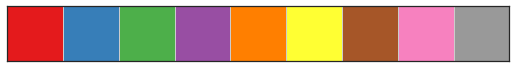

In [10]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(5+1, l=.6, s=1.0))
current_palette = sns.color_palette('Set1')

sns.palplot(current_palette)
current_palette = np.asarray(current_palette)


In [11]:
import matplotlib.pyplot as plt
figsiz_=(7*3,2.5)

color_list = ['r','b','g'] 
predicted_model_list = ['gpind','gpdep','baselatent']

delta = 0.2
y_ = 5
xlim_=[0-delta,6+delta]
ylim_=[-y_-delta,y_+delta]
alpha_=0.25


train_range=[0,3]
fontsiz_ = 13
ncontext='10'

In [12]:
modelname_dict = {'basedeep':'ConvCNP', 'baselatentdeep':'ConvLNP', 'gpinddeep':'GPConvCNP-SM' , 'gpindrbfdeep':'GPConvCNP-RBF', 'gpdepdeep':'Proposed (Bayesian)'}


----------------------------------------------------------------------------------------------------
loaded model: ConvCNP
----------------------------------------------------------------------------------------------------
current task idx: 2
xc.shape,yc.shape,xstar.shape,ystar.shape
torch.Size([16, 10, 3]) torch.Size([16, 10, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])


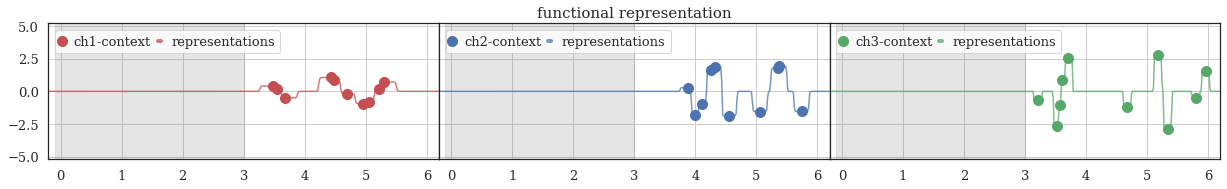

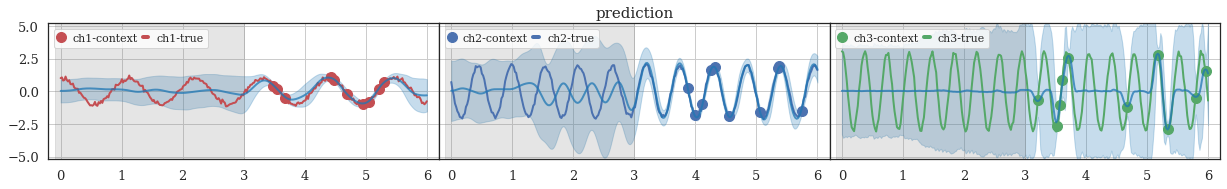

current task idx: 16
xc.shape,yc.shape,xstar.shape,ystar.shape
torch.Size([16, 10, 3]) torch.Size([16, 10, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])


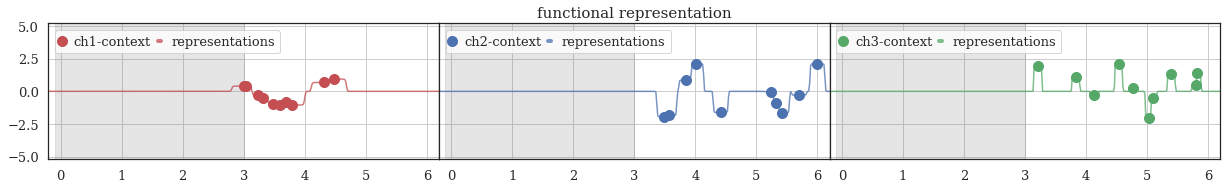

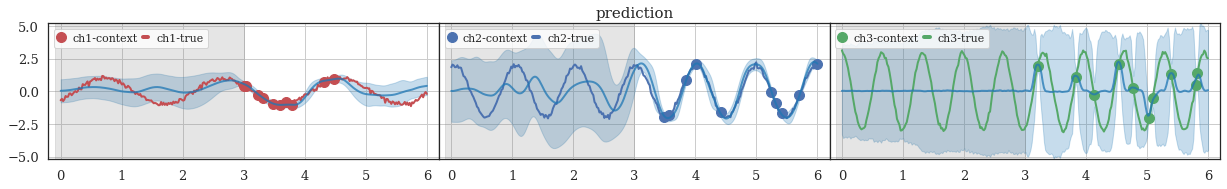




spikeslab version 7 with tempering 0.1
----------------------------------------------------------------------------------------------------
loaded model: Proposed (Bayesian)
----------------------------------------------------------------------------------------------------
current task idx: 2
xc.shape,yc.shape,xstar.shape,ystar.shape
torch.Size([16, 10, 3]) torch.Size([16, 10, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])


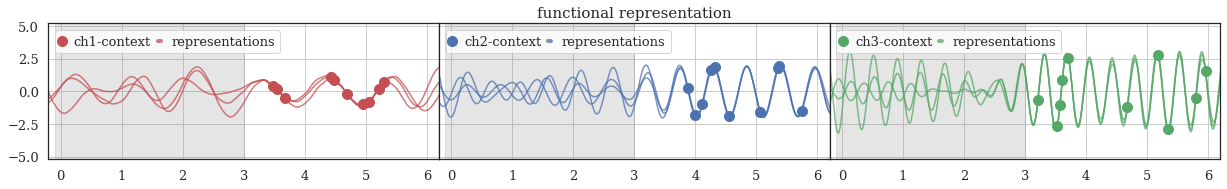

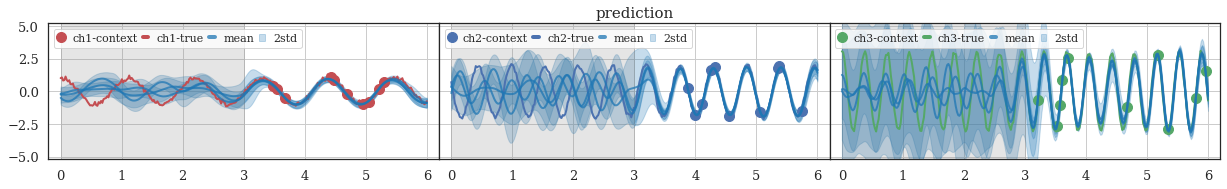

current task idx: 16
xc.shape,yc.shape,xstar.shape,ystar.shape
torch.Size([16, 10, 3]) torch.Size([16, 10, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])


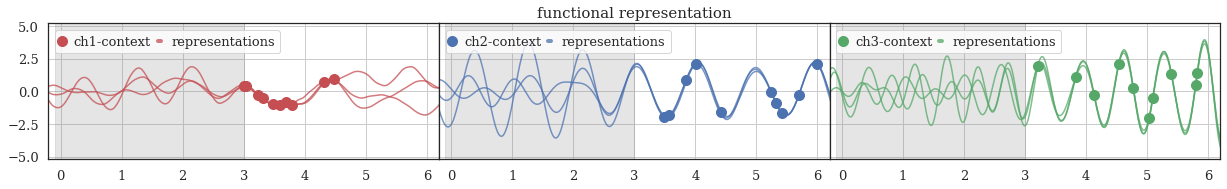

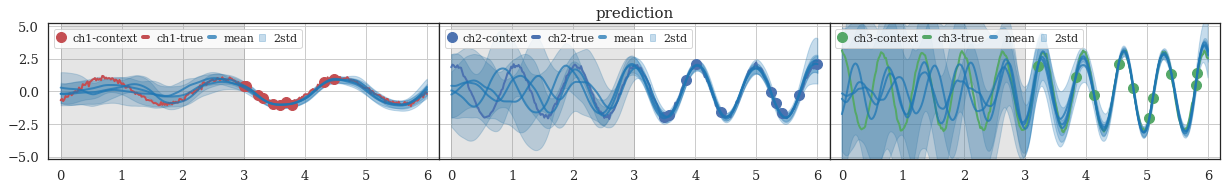




----------------------------------------------------------------------------------------------------
loaded model: GPConvCNP-RBF
----------------------------------------------------------------------------------------------------
current task idx: 2
xc.shape,yc.shape,xstar.shape,ystar.shape
torch.Size([16, 10, 3]) torch.Size([16, 10, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])


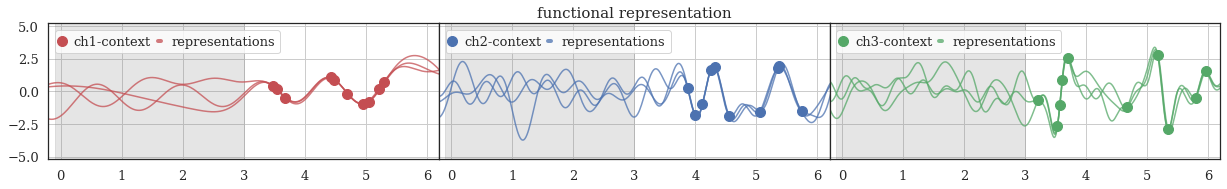

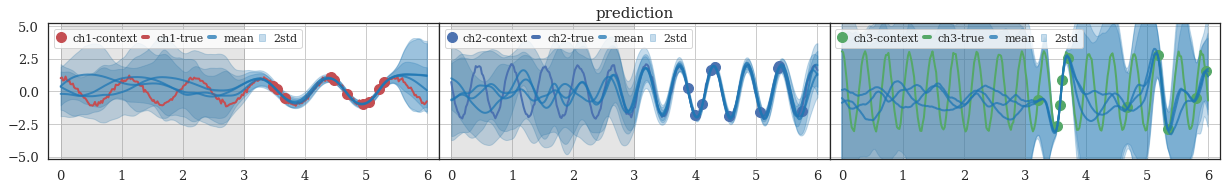

current task idx: 16
xc.shape,yc.shape,xstar.shape,ystar.shape
torch.Size([16, 10, 3]) torch.Size([16, 10, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])


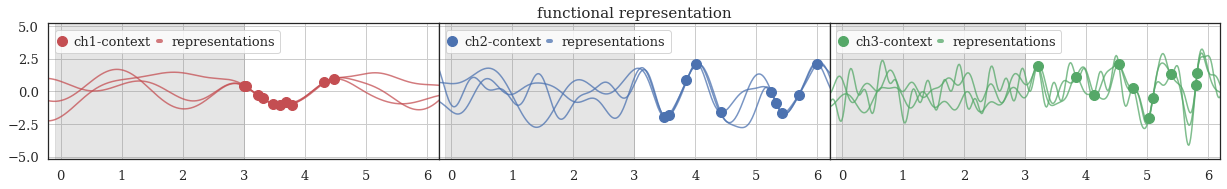

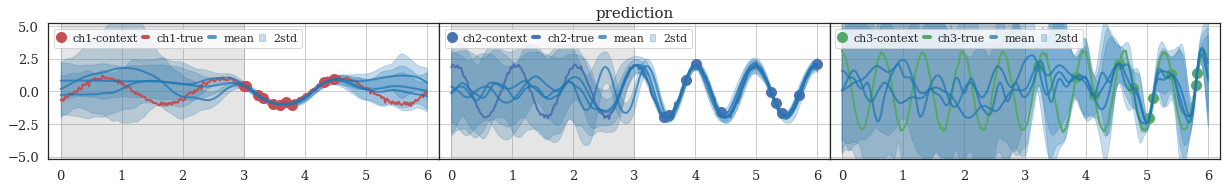

In [13]:
import torch.nn.functional as F
import os

chosen_idx=12
idx = 6 

model_list = []
weight_list = []
for saved_modelparam_path in saved_modelparam_path_list:

    #_,_,param_saved,param_detail = saved_modelparam_path.split('/')
    _,_,param_saved,param_detail = saved_modelparam_path.split('/')
    
    tasktype = param_saved.split('_')[1]
    deptype = param_detail.split('_')[0]    
    dep=True if deptype == 'depTrue' else False
    deptype = param_detail.split('_')[0]
    modelname = param_detail.split('_')[2]
    cnntype = param_detail.split('_')[4]

    model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
    saved_dict = torch.load(saved_modelparam_path)
    model.load_state_dict(saved_dict['state_dict'])
    tmp_numsamples = 3
    model.num_samples = tmp_numsamples    
    
    if modelname in ['gpdep']:
        model_list.append(model)



    save_path_set = './syndata_{}_varyingnct/dep{}_{}_ncontext{}'.format(tasktype, dep, testtype, ncontext)    
    print('-'*100)
    #print('savepatt_set: {}'.format(save_path_set))
    #print('loaded model: {}'.format(saved_modelparam_path))
    print('loaded model: {}'.format(modelname_dict[modelname+cnntype]))
    print('-'*100)

    
    
    
    loaded = torch.load(save_path_set + '.db')
    train_set = loaded['valid_set']
        
    #-----------------------------------
    #predict
    #-----------------------------------
    #idx_list=np.sort(np.random.randint(0,16,2))
    idx_list=[2,16]
    
    for chosen_idx in idx_list:    
        
        xc,yc,xt,yt,xf,yf = train_set[chosen_idx]
        xc_ = xc[idx][...,None,:].unsqueeze(dim=0)
        yc_ = yc[idx].unsqueeze(dim=0)
        #yc_ = 0.*yc[idx].unsqueeze(dim=0)        # counter example, memorization does nor happen in our model
        xt_ = xt[idx][...,None,:].unsqueeze(dim=0)
        yt_ = yt[idx].unsqueeze(dim=0)
        xf_ = xf[idx][...,None,:].unsqueeze(dim=0)
        yf_ = yf[idx].unsqueeze(dim=0)

        xstar,ystar = xf_,yf_     
        #xstar,ystar = xt_,yt_     
        
        #print('')
        print('current task idx: {}'.format(chosen_idx))
        print('xc.shape,yc.shape,xstar.shape,ystar.shape')
        print(xc.shape,yc.shape,xstar.shape,ystar.shape)



            
        #--------------------------------------------------------------------------------
        #functional representaions
        #--------------------------------------------------------------------------------            
        model.eval()        
        if model.modelname in proposed_model_list:
            post_samples,xa = model.sample_functionalfeature(xc_.cuda(),yc_.cuda(),xstar.cuda(),numsamples=tmp_numsamples)
            model.num_samples = tmp_numsamples 

        else:
            post_samples,xa = model.sample_functionalfeature(xc_[:,:,0,:].cuda(),yc_.squeeze().cuda(),xstar[:,:,0,:].cuda(),numsamples=1)
            post_samples = post_samples[:,None,:,:]
        
            
            
        _ , axs = plt.subplots(1, 3,figsize=figsiz_ , sharey=True)            
        plt.subplots_adjust( wspace=0.0, hspace=0.0)
                
        for i in range(nchannels):
            axs[i].axvspan(xmin = train_range[0]-0.1,xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.2)    #,label = 'train range'        
            axs[i].plot(xc_[0,:,0,i].cpu().data.numpy(),yc_[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10,label='ch{}-context'.format(i+1),alpha=1.0)    

            for j in range(post_samples.size(1)):
                #plt.plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i]+'-s',markersize=2)        
                if j==0:
                    axs[i].plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i],alpha=0.75,linewidth=1.5,label='representations')            
                else:
                    axs[i].plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i],alpha=0.75,linewidth=1.5)        
    
            axs[i].xaxis.set_tick_params(labelsize=fontsiz_)
            axs[i].yaxis.set_tick_params(labelsize=fontsiz_)                    
            axs[i].set_xlim(xlim_)
            axs[i].set_ylim(ylim_)
            
            
            if i==1:
                axs[i].set_title('functional representation',fontsize=fontsiz_+2)
            

            leg=axs[i].legend(loc='upper left',fontsize=fontsiz_,ncol=4,labelspacing=1.0,handlelength=0.25,columnspacing=0.5)
            for line in leg.get_lines():
                line.set_linewidth(4) 
                line.set_markersize(4)               
                
                
            
        #--------------------------------------------------------------------------------
        #prediction
        #--------------------------------------------------------------------------------
        model.eval()
        if model.modelname in proposed_model_list:
            outs = model(xc_.cuda(),yc_.cuda(),xstar.cuda())       
        else:
            outs = model(xc_[:,:,0,:].cuda(),yc_.cuda(),xstar[:,:,0,:].cuda())       
        
        
        if (hasattr(model,'gpsampler'))  and (hasattr(model.gpsampler,'neural_loglogits')):
            #print(F.softmax(model.gpsampler.neural_loglogits,dim=-1))
            weight_list.append(F.softmax(model.gpsampler.neural_loglogits,dim=-1).cpu().data.numpy().round(3))
            
        
        
        
        pmu_xt,pstd_xt = outs.pymu,outs.pystd
        _, axs = plt.subplots(1, 3,figsize=figsiz_ , sharey=True)            
        plt.subplots_adjust( wspace=0.0, hspace=0.0)                
        color_list = ['r','b','g']
        if model.modelname in predicted_model_list:
            for i in range(nchannels):
                axs[i].axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.2)    #,label = 'train range'        
                axs[i].plot(xc_[0,:,0,i].cpu().data.numpy(),yc_[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10,label='ch{}-context'.format(i+1),alpha=1.0)    
                axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),ystar[0,:,i].cpu().data.numpy(),color_list[i],markersize=5,label = 'ch{}-true'.format(i+1),linewidth=2.0)                
                

                for j in range(model.num_samples):
                    if j ==0:
                        axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),
                                    pmu_xt[j,0,:,i].cpu().data.numpy(),
                                    color='tab:blue',
                                    linewidth=2.,
                                    alpha=3*alpha_,
                                    label='mean') #,label = 'Model'

                        axs[i].fill_between(xstar[0,:,0,i].cpu().data.numpy(),
                                         (pmu_xt+2*pstd_xt)[j,0,:,i].cpu().data.numpy(),
                                         (pmu_xt-2*pstd_xt)[j,0,:,i].cpu().data.numpy(),
                                         color='tab:blue', alpha=alpha_,
                                         label='2std')                
                        
                    else:
                        axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),
                                    pmu_xt[j,0,:,i].cpu().data.numpy(),
                                    color='tab:blue',
                                    linewidth=2.,
                                    alpha=3*alpha_) #,label = 'Model'

                        axs[i].fill_between(xstar[0,:,0,i].cpu().data.numpy(),
                                         (pmu_xt+2*pstd_xt)[j,0,:,i].cpu().data.numpy(),
                                         (pmu_xt-2*pstd_xt)[j,0,:,i].cpu().data.numpy(),
                                         color='tab:blue', alpha=alpha_)                                    
                        
                        
                    if i==1:
                        axs[i].set_title('prediction',fontsize=fontsiz_+2)
                    axs[i].xaxis.set_tick_params(labelsize=fontsiz_)
                    axs[i].yaxis.set_tick_params(labelsize=fontsiz_)                    
                    axs[i].set_xlim(xlim_)
                    axs[i].set_ylim(ylim_)
                    leg=axs[i].legend(loc='upper left',fontsize=11,ncol=5,columnspacing=0.5,handlelength=0.5,handletextpad=.75)    
                    for line in leg.get_lines():
                        line.set_linewidth(4) 
                        line.set_markersize(4)     
                                        
                            
                        
                        

        else:

            for i in range(nchannels):
                axs[i].axvspan(xmin = train_range[0]-0.1,xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.2) #,label = 'train range'
                axs[i].plot(xc_[0,:,0,i].cpu().data.numpy(),yc_[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10,label='ch{}-context'.format(i+1),alpha=1.0)    
                axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),ystar[0,:,i].cpu().data.numpy(),color_list[i],markersize=5,label = 'ch{}-true'.format(i+1),linewidth=2.0)                
                axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),
                            pmu_xt[0,:,i].cpu().data.numpy(),
                            color='tab:blue',
                            linewidth=2.,
                            alpha=3*alpha_)   #,label = 'Model'         
                
                axs[i].fill_between(xstar[0,:,0,i].cpu().data.numpy(),
                                 (pmu_xt+2*pstd_xt)[0,:,i].cpu().data.numpy(),
                                 (pmu_xt-2*pstd_xt)[0,:,i].cpu().data.numpy(),
                                 color='tab:blue', alpha=alpha_)                

                
                axs[i].xaxis.set_tick_params(labelsize=fontsiz_)
                
                axs[i].yaxis.set_tick_params(labelsize=fontsiz_)                    
                axs[i].set_xlim(xlim_)
                axs[i].set_ylim(ylim_)
                
                if i==1:
                    axs[i].set_title('prediction',fontsize=fontsiz_+2)
                
                

                leg=axs[i].legend(loc='upper left',fontsize=11,ncol=5,columnspacing=0.5,handlelength=0.5,handletextpad=.75)    
                for line in leg.get_lines():
                    line.set_linewidth(4) 
                    line.set_markersize(4)     

                

        
        #savefig_dir = './fig_{}_dep{}/'.format(datatype,dep)
        #if not os.path.isdir(savefig_dir):
        #    os.makedirs(savefig_dir)    
        
        #savefigname = savefig_dir + datatype  + '_datav{}_dep{}_{}_ncontext{}_idx{}_together'.format(datav,str(dep).lower(), modelname ,ncontext,chosen_idx) 
        #print('savefigname: {}'.format(savefigname))
        #plt.savefig(savefigname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
        plt.show()
    
    print('\n'*2)


# qualitative analysis of the estiamted parameters

## spectral density

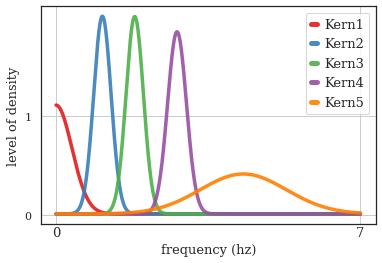

In [16]:
tmp_model = model_list[0]
mu,inv_std = tmp_model.gpsampler.logmu.exp(),1/(tmp_model.gpsampler.logstd.exp()+1e-4)
mu,inv_std

modelname  = 'gpdep'
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .001 steps.

x_axis = np.arange(0, 7, 0.001)
#figsiz__=(3,2.7)
#figsiz__=(8,5)
figsiz__=(6,4)

fig, ax = plt.subplots(figsize=figsiz__)
ax.tick_params(axis="x",direction="in", pad=2)

for i,(imu,istd) in enumerate(zip(mu,inv_std)):
    plt.plot(x_axis, .01+norm.pdf(x_axis,imu.cpu().data.numpy(),1*istd.cpu().data.numpy()),
             linewidth=3.5,
             alpha=0.9,
             color=current_palette[i],
             label = 'Kern{}'.format(i+1))



    
plt.yticks([0,1])
plt.xticks([0,7])

plt.xlabel('frequency (hz)',fontsize=13)
plt.ylabel('level of density',fontsize=13)
plt.xticks(fontsize=13)
leg=plt.legend(loc='upper right',fontsize=13,ncol=1,columnspacing=0.5,handlelength=0.5,handletextpad=.5)

for line in leg.get_lines():
    line.set_linewidth(5) 
    line.set_markersize(5)     

# savefigname = savefig_dir + datatype  + '_datav{}_dep{}_{}_density_withleg'.format(datav,str(dep).lower(), modelname )  
# print('savefigname: {}'.format(savefigname))
# plt.savefig(savefigname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()

## P_{traninv-NN}(Xc,Yc)

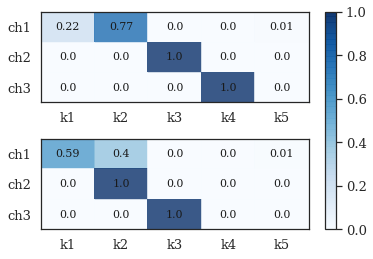

In [17]:
from matplotlib.ticker import FuncFormatter

ynames_list = ['ch1','ch2','ch3']
xnames_list = ['k1','k2','k3','k4','k5']
#figsiz_=(3,2.7)
figsiz_=(6,4)
#fontsiz_=15.0
modelname='gpdep'


fig, axes = plt.subplots(2, 1,figsize=figsiz_ , sharey=True)      
plt.subplots_adjust( wspace=0.0, hspace=0.4)     
plt.gca().invert_yaxis()

for k,ax in enumerate(axes.flat):
    im = ax.pcolormesh(weight_list[k][0,:], cmap='Blues', vmin=0, vmax=1.0,alpha=0.8)

    ax.set_xticks(np.arange(len(xnames_list))+0.5)
    ax.set_xticklabels(xnames_list,fontsize=fontsiz_)
    
    ax.set_yticks(np.arange(len(ynames_list))+0.5)
    ax.set_yticklabels(ynames_list,fontsize=fontsiz_)
    
    for i in range(len(ynames_list)):
        for j in range(len(xnames_list)):
            text = ax.text(j+0.5, i+0.5, weight_list[k][0,i,j].round(2),
                           ha="center", va="center", color="k",fontsize=fontsiz_-2)    
    
ticks = [0.0,0.2,0.4,0.6,0.8,1.0]
cbar=fig.colorbar(im, ax=axes.flat,ticks=ticks)

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(fontsiz_)

# savefigname = savefig_dir + datatype  + '_datav{}_dep{}_{}_weight'.format(datav,str(dep).lower(), modelname )  
# print('savefigname: {}'.format(savefigname))
# plt.savefig(savefigname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()